# Text to Speech
> Generating synthetic voice from the given text using open-source TTS models.

- toc: false
- badges: true
- comments: true
- categories: [tts, audio]

In [ ]:
TEXT = "hello homosapien, I am a synthetic voice created by Sparsh"

## Tacotron2 + WaveGlow

In [1]:
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/NVIDIA/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 9168aea
  !pip install -q librosa unidecode
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

TensorFlow 1.x selected.
Previous HEAD position was 4b1001f Merge branch 'master' of https://github.com/NVIDIA/waveglow
HEAD is now at 9168aea README.md: layout
     |████████████████████████████████| 245kB 2.8MB/s 


In [2]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

tacotron2_pretrained_model = 'tacotron2_statedict.pt'
if not exists(tacotron2_pretrained_model):
  # download the Tacotron2 pretrained model
  download_from_google_drive('1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA', tacotron2_pretrained_model)
waveglow_pretrained_model = 'waveglow_old.pt'
if not exists(waveglow_pretrained_model):
  # download the Waveglow pretrained model  
  download_from_google_drive('1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx', waveglow_pretrained_model)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1012      0 --:--:-- --:--:-- --:--:--  1014
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  107M    0  107M    0     0  24.1M      0 --:--:--  0:00:04 --:--:-- 58.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1030      0 --:--:-- --:--:-- --:--:--  1027
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  644M    0  644M    0     0  58.1M      0 --:--:--  0:00:11 --:--:-- 83.1M


In [3]:
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='viridis')

torch.set_grad_enabled(False)
        
# initialize Tacotron2 with the pretrained model
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()#.half()

# initialize Waveglow with the pretrained model
# waveglow = torch.load(waveglow_pretrained_model)['model']
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182
import json
from glow import WaveGlow
waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']
waveglow = WaveGlow(**waveglow_config)
waveglow.load_state_dict(torch.load(waveglow_pretrained_model)['model'].state_dict())
_ = waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

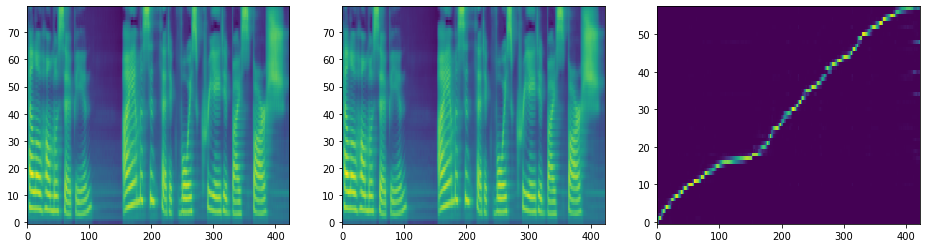

In [5]:
sequence = np.array(text_to_sequence(TEXT, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).long()
sequence = sequence.cuda()

mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

In [6]:
audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

In [7]:
# remove waveglow bias
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)

## ESPnet real time E2E-TTS demonstration

This notebook provides a demonstration of the realtime E2E-TTS using ESPnet-TTS and ParallelWaveGAN (+ MelGAN).

- ESPnet: https://github.com/espnet/espnet
- ParallelWaveGAN: https://github.com/kan-bayashi/ParallelWaveGAN

In [9]:
# install minimal components
!pip install -q parallel_wavegan PyYaml unidecode ConfigArgparse g2p_en nltk
!git clone -q https://github.com/espnet/espnet.git
!cd espnet && git fetch && git checkout -b v.0.6.1 1e8b6ce88d57b53d1b60cbb3f306652468b0ab63

     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 3.1MB 39.5MB/s 
     |████████████████████████████████| 1.6MB 48.5MB/s 
     |████████████████████████████████| 184kB 62.2MB/s 
Switched to a new branch 'v.0.6.1'


In [10]:
# download pretrained model
import os
if not os.path.exists("downloads/en/transformer"):
    !./espnet/utils/download_from_google_drive.sh \
        https://drive.google.com/open?id=1z8KSOWVBjK-_Ws4RxVN4NTx-Buy03-7c downloads/en/transformer tar.gz

# set path
trans_type = "phn"
dict_path = "downloads/en/transformer/data/lang_1phn/phn_train_no_dev_units.txt"
model_path = "downloads/en/transformer/exp/phn_train_no_dev_pytorch_train_pytorch_transformer.v3.single/results/model.last1.avg.best"

print("sucessfully finished download.")

--2020-04-23 19:43:07--  https://drive.google.com/uc?export=download&id=1z8KSOWVBjK-_Ws4RxVN4NTx-Buy03-7c
Resolving drive.google.com (drive.google.com)... 172.217.4.174, 2607:f8b0:4007:803::200e
Connecting to drive.google.com (drive.google.com)|172.217.4.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘downloads/en/transformer/EJmpGT.tar.gz’

downloads/en/transf     [ <=>                ]   3.23K  --.-KB/s    in 0s      

2020-04-23 19:43:07 (23.9 MB/s) - ‘downloads/en/transformer/EJmpGT.tar.gz’ saved [3305]


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3305    0  3305    0     0   8956      0 --:--:-- --:--:-- --:--:--  8956
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Curren

In [11]:
# download pretrained model
import os
if not os.path.exists("downloads/en/parallel_wavegan"):
    !./espnet/utils/download_from_google_drive.sh \
        https://drive.google.com/open?id=1Grn7X9wD35UcDJ5F7chwdTqTa4U7DeVB downloads/en/parallel_wavegan tar.gz

# set path
vocoder_path = "downloads/en/parallel_wavegan/ljspeech.parallel_wavegan.v2/checkpoint-400000steps.pkl"
vocoder_conf = "downloads/en/parallel_wavegan/ljspeech.parallel_wavegan.v2/config.yml"

print("Sucessfully finished download.")

--2020-04-23 19:43:18--  https://drive.google.com/uc?export=download&id=1Grn7X9wD35UcDJ5F7chwdTqTa4U7DeVB
Resolving drive.google.com (drive.google.com)... 172.217.14.78, 2607:f8b0:4007:801::200e
Connecting to drive.google.com (drive.google.com)|172.217.14.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6i824otlc8vf6svrn5ibifrvff194os3/1587670950000/04214513489132088126/*/1Grn7X9wD35UcDJ5F7chwdTqTa4U7DeVB?e=download [following]
--2020-04-23 19:43:20--  https://doc-0o-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6i824otlc8vf6svrn5ibifrvff194os3/1587670950000/04214513489132088126/*/1Grn7X9wD35UcDJ5F7chwdTqTa4U7DeVB?e=download
Resolving doc-0o-30-docs.googleusercontent.com (doc-0o-30-docs.googleusercontent.com)... 172.217.14.97, 2607:f8b0:4007:80e::2001
Connecting to doc-0o-30-docs.googleusercontent.com (doc-0o-30-docs.goo

In [12]:
# add path
import sys
sys.path.append("espnet/egs/ljspeech/tts1/local")
sys.path.append("espnet")

# define device
import torch
device = torch.device("cuda")

# define E2E-TTS model
from argparse import Namespace
from espnet.asr.asr_utils import get_model_conf
from espnet.asr.asr_utils import torch_load
from espnet.utils.dynamic_import import dynamic_import
idim, odim, train_args = get_model_conf(model_path)
model_class = dynamic_import(train_args.model_module)
model = model_class(idim, odim, train_args)
torch_load(model_path, model)
model = model.eval().to(device)
inference_args = Namespace(**{
    "threshold": 0.5,"minlenratio": 0.0, "maxlenratio": 10.0,
    "use_attention_constraint": True,
    "backward_window": 1, "forward_window":3,
    })

# define neural vocoder
import yaml
import parallel_wavegan.models
with open(vocoder_conf) as f:
    config = yaml.load(f, Loader=yaml.Loader)
vocoder_class = config.get("generator_type", "ParallelWaveGANGenerator")
vocoder = getattr(parallel_wavegan.models, vocoder_class)(**config["generator_params"])
vocoder.load_state_dict(torch.load(vocoder_path, map_location="cpu")["model"]["generator"])
vocoder.remove_weight_norm()
vocoder = vocoder.eval().to(device)

# define text frontend
from text.cleaners import custom_english_cleaners
from g2p_en import G2p
with open(dict_path) as f:
    lines = f.readlines()
lines = [line.replace("\n", "").split(" ") for line in lines]
char_to_id = {c: int(i) for c, i in lines}
g2p = G2p()
def frontend(text):
    """Clean text and then convert to id sequence."""
    text = custom_english_cleaners(text)
    
    if trans_type == "phn":
        text = filter(lambda s: s != " ", g2p(text))
        text = " ".join(text)
        print(f"Cleaned text: {text}")
        charseq = text.split(" ")
    else:
        print(f"Cleaned text: {text}")
        charseq = list(text)
    idseq = []
    for c in charseq:
        if c.isspace():
            idseq += [char_to_id["<space>"]]
        elif c not in char_to_id.keys():
            idseq += [char_to_id["<unk>"]]
        else:
            idseq += [char_to_id[c]]
    idseq += [idim - 1]  # <eos>
    return torch.LongTensor(idseq).view(-1).to(device)

import nltk
nltk.download('punkt')
print("Now ready to synthesize!")

/usr/local/lib/python3.6/dist-packages/chainer/_environment_check.py:77: UserWarning: Failed to check requirement: cupy-cuda101>=6.5.0,<7.0.0
  'Failed to check requirement: {}'.format(requirement))


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Now ready to synthesize!


In [13]:
import time
print("Input your favorite sentence in English!")
input_text = input()
pad_fn = torch.nn.ReplicationPad1d(
    config["generator_params"].get("aux_context_window", 0))
use_noise_input = vocoder_class == "ParallelWaveGANGenerator"
with torch.no_grad():
    start = time.time()
    x = frontend(input_text)
    c, _, _ = model.inference(x, inference_args)
    c = pad_fn(c.unsqueeze(0).transpose(2, 1)).to(device)
    xx = (c,)
    if use_noise_input:
        z_size = (1, 1, (c.size(2) - sum(pad_fn.padding)) * config["hop_size"])
        z = torch.randn(z_size).to(device)
        xx = (z,) + xx
    y = vocoder(*xx).view(-1)
rtf = (time.time() - start) / (len(y) / config["sampling_rate"])
print(f"RTF = {rtf:5f}")

from IPython.display import display, Audio
display(Audio(y.view(-1).cpu().numpy(), rate=config["sampling_rate"]))

Input your favorite sentence in English!
hello homosapien, I am a synthetic voice created by Sparsh
Cleaned text: HH AH0 L OW1 HH OW0 M OW0 S EY1 P IY0 AH0 N , AY1 AE1 M AH0 S IH0 N TH EH1 T IH0 K V OY1 S K R IY0 EY1 T AH0 D B AY1 S P AA1 R SH
RTF = 0.904254
